In [1]:
import scipy as sp
import numpy as np
from pylab import *
import seaborn as sns
from tqdm import tqdm
import scipy
import joblib
%config InlineBackend.figure_format='retina'


import sys, os
sys.path.append("..")
import config

In [ ]:
def roll_zeropad(a, shift, axis=None):
    """
    Roll array elements along a given axis.

    Elements off the end of the array are treated as zeros.

    Parameters
    ----------
    a : array_like
        Input array.
    shift : int
        The number of places by which elements are shifted.
    axis : int, optional
        The axis along which elements are shifted.  By default, the array
        is flattened before shifting, after which the original
        shape is restored.

    Returns
    -------
    res : ndarray
        Output array, with the same shape as `a`.

    See Also
    --------
    roll     : Elements that roll off one end come back on the other.
    rollaxis : Roll the specified axis backwards, until it lies in a
               given position.

    Examples
    --------
    >>> x = np.arange(10)
    >>> roll_zeropad(x, 2)
    array([0, 0, 0, 1, 2, 3, 4, 5, 6, 7])
    >>> roll_zeropad(x, -2)
    array([2, 3, 4, 5, 6, 7, 8, 9, 0, 0])

    """
    a = np.asanyarray(a)
    if shift == 0: return a
    if axis is None:
        n = a.size
        reshape = True
    else:
        n = a.shape[axis]
        reshape = False
    if np.abs(shift) > n:
        res = np.zeros_like(a)
    elif shift < 0:
        shift += n
        zeros = np.zeros_like(a.take(np.arange(n-shift), axis))
        res = np.concatenate((a.take(np.arange(n-shift,n), axis), zeros), axis)
    else:
        zeros = np.zeros_like(a.take(np.arange(n-shift,n), axis))
        res = np.concatenate((zeros, a.take(np.arange(n-shift), axis)), axis)
    if reshape:
        return res.reshape(a.shape)
    else:
        return res
    
    
def Pulse2(x, tau_r, tau_f1, tau_f2, A1, A2, t0, A0):
    # Test: plot(np.linspace(-50,50,200), Pulse3(np.linspace(-50,50,200), 2,4,10,20,3,2,1,10.5,5))
    times=x-t0
    mask =times>0
    pulse = (A1     *     (np.exp(-times[mask] / tau_f1))
            +A2     *     (np.exp(-times[mask] / tau_f2))
            -(A1+A2) * (np.exp(-times[mask] / tau_r))
            )
    pulse = np.concatenate((np.zeros(sum(~mask)), pulse))
    pulse/=max(pulse)
    pulse*=A0
    return pulse




def get_trigger_times(t_fiber = 2.1,t_scint = 5.2,signal_npe = 6,
                          threshold = 1.5,
                          sipm_pulseshape_time = [], sipm_pulseshape_voltage=[],
                          N_sample= 10_000):
    """
    Calculate the trigger threshold on real events given a treshold set on dark current in unit of pe.
    The real event is smeared out because of the time constants
    
    Return: 
        trigger_time: with dimesion of (N_sample, len(threshold))
    """
    t_sample_fiber = np.random.exponential(t_fiber, (N_sample,signal_npe))
    t_sample_scint = np.random.exponential(t_scint, (N_sample,signal_npe))
    t_sample = np.sort(t_sample_fiber+t_sample_scint, axis=1)
    
    time_max = max(sipm_pulseshape_time)
    time_interval = sipm_pulseshape_time[1]-sipm_pulseshape_time[0]
    trigger_time = np.zeros(N_sample)
    # Normalize to 1
    pulse_template = sipm_pulseshape_voltage/max(sipm_pulseshape_voltage)
    for ievent in range(N_sample):
        # Make the artificial pulse
        pulse = np.zeros_like(sipm_pulseshape_time)
        for t in t_sample[ievent]:
            pulse += roll_zeropad(pulse_template, int(t//time_interval))
            
            
        # Find trigger threshold
        trigger_time[ievent] = sipm_pulseshape_time[np.argmax(pulse>np.floor(threshold)+0.5)]
     
    return trigger_time



def sim_real_bar(t_fiber = 2.1,t_scint = 5.2,
                          threshold = 1.5,
                          attenuation_first = 1, attenuation_second = 1, 
                          photon_source_pdf = [],
                          sipm_pulseshape_time = [], sipm_pulseshape_voltage=[],
                          N_sample= 10_000):
    

    
    return

def process_dt(trigger_time):
    """
    Return: 
        dt_width: equivalent sigma of single channel, 1-D list with length of (len(threshold))
    """    
    t = trigger_time
    dt = (t[:len(t)//2]- t[len(t)//2:])/np.sqrt(2)
    # Use the width of middle 76% quantile to estimate the sigma
    dt_width = np.diff(np.quantile(dt, [0.115, 1-0.115], axis=0), axis=0)/(2*np.sqrt(2*np.log(2)))
    
    return dt_width

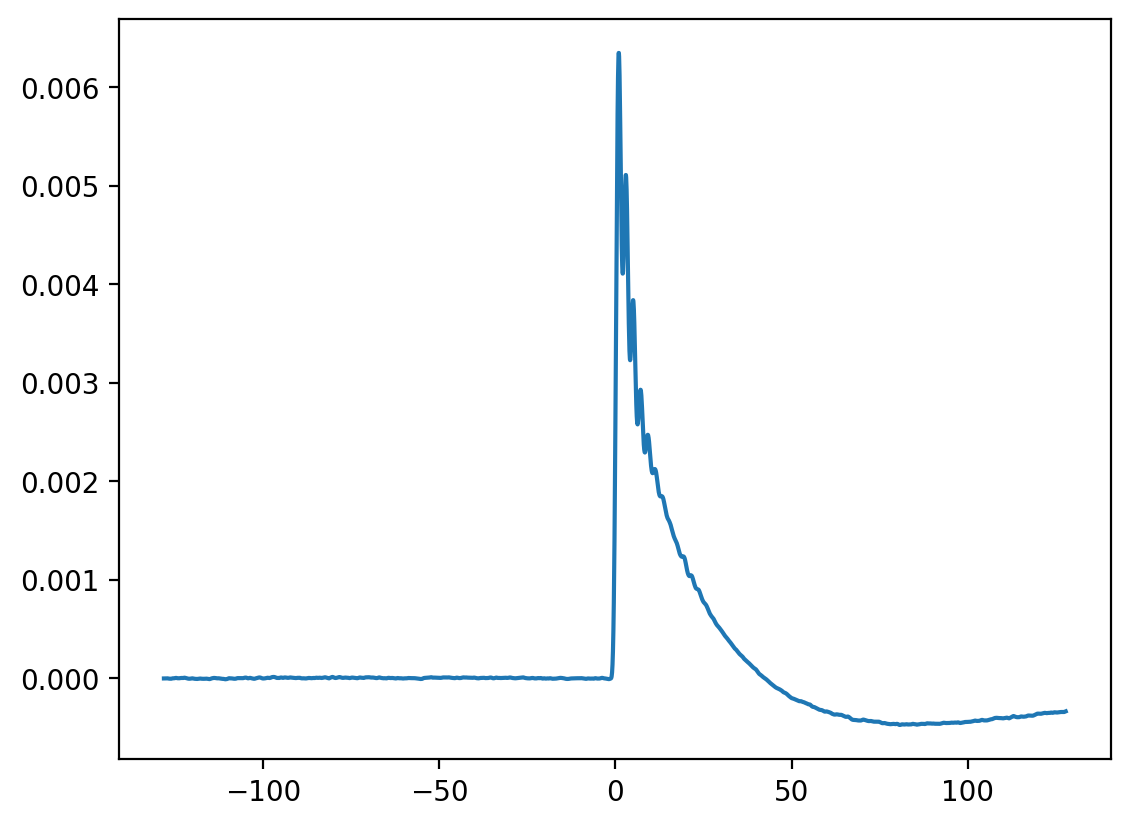

In [42]:
# Physics parameter
t_fiber = 2.1
t_scint = 6

# Simulation setting
N_sample= 10_000

# Parameters to scan:
threshold_list = [0,1,2,3,4]
signal_npe_list = np.arange(1,15)

# Make an artificial template
pulse_template_t = np.linspace(-120,120,2000)
pulse_template = Pulse2(pulse_template_t, 0.7, 0.73, 6, 0.7, 0.3, 0,1)

# template_name = config.scope+"pulse_shape/averaged_pulse_1pe_preamp_v4_40.7V.pkl"
# template_name = config.scope+"pulse_shape/averaged_pulse_1pe_preamp_v4b_200MHz_40.7V.pkl"
# template_name = config.scope+"pulse_shape/averaged_pulse_1pe_preamp_v4c_200MHz_40.7V.pkl"
# template_name = config.scope+"pulse_shape/preamp_v5_0pF_averaged.joblib"
template_name = config.scope+"pulse_shape/preamp_v5_30pF_averaged.joblib"
d = joblib.load(template_name)
pulse_template_t = d["time_series_ns"]
pulse_template = d["averaged_pulse_1pe_volt"]

plot(pulse_template_t, pulse_template)



In [43]:
# # Generate events
results_raw = np.zeros((len(signal_npe_list), len(threshold_list)))
for ipe, npe in enumerate(tqdm(signal_npe_list)):
    trigger_time = sim_trigger_threshold(t_fiber = t_fiber,t_scint = t_scint,signal_npe = npe,
                              threshold_list = threshold_list,
                              sipm_pulseshape_time = pulse_template_t, sipm_pulseshape_voltage=pulse_template,
                              N_sample= N_sample)
    efficiencies = [sum(trigger_time[:,i]>0)/len(trigger_time[:,i]) for i in range(trigger_time.shape[1])]
    results_raw[ipe] = efficiencies

100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


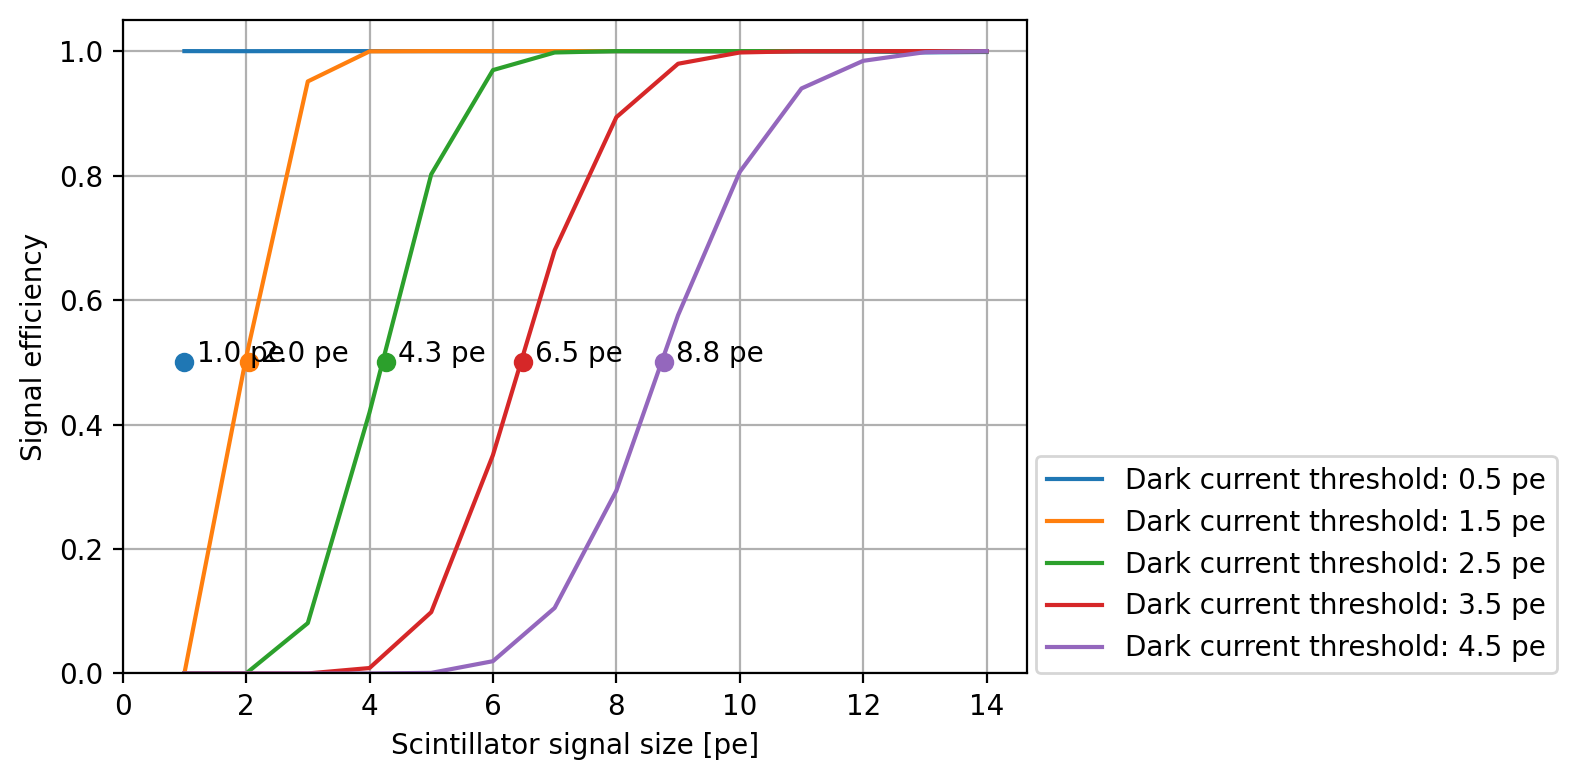

In [45]:
figure(figsize=(8,4))
for ith, th in enumerate(threshold_list):
    plot(signal_npe_list, results_raw[:,ith], label=f"Dark current threshold: {th+0.5} pe")
    f_ = scipy.interpolate.interp1d(signal_npe_list, results_raw[:,ith])
    npe = np.linspace(min(signal_npe_list), max(signal_npe_list),200)
    eff = f_(npe)
    threshold = npe[np.argmax(eff>0.5)]
    plot(threshold, 0.5, color=f"C{ith}", marker="o")
    annotate(f"{threshold:.1f} pe",xy=(threshold+0.2, 0.5))
    
    
xlabel("Scintillator signal size [pe]")
ylabel("Signal efficiency")
legend(loc=(1.01,0))
grid()
xlim(0,)
ylim(0,)
tight_layout()
savefig(os.path.splitext(template_name)[0]+"_threshold_estimate.jpg")

In [59]:
def coinc_rate(N, R, dt):
    return N*R, N*R* N*R*dt, N*R*2*R*dt

def coinc_rate_reduction(N, R, dt):
    return N*R*dt, 2*R*dt


N=80
R=10e3
dt=50e-9
print(coinc_rate(N, R, dt))
coinc_rate_reduction(N, R, dt)

(800000.0, 32000.0, 800.0)


(0.04, 0.001)

---
dev